In [1]:
import surprise
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sparse
import numpy as np
from scipy.sparse.linalg import spsolve

In [2]:
# surprise모듈을 이용해 무비렌즈의 10만개 sample data set 불러오기
data = surprise.Dataset.load_builtin('ml-100k')

In [3]:
# data를 df로 저장하고 column명 지정
df = pd.DataFrame(data.raw_ratings, columns=["user", "item", "rate", "id"])
# id 칼럼 삭제
del df["id"]
# df 확인
df.head()

,user,item,rate
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


In [4]:
# unique한 사용자와 item의 수 확인
n_users = df['user'].unique().shape[0]
n_items = df['item'].unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))

Number of users = 943 | Number of movies = 1682


In [5]:
# rate 분포 확인
df.rate.describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rate, dtype: float64

In [6]:
# df를 유틸리티 행렬(rating matrix) 형태로 만들기(x축이 상품, y축이 사용자)
# set_index: parameter를 dataframe의 index로 변경
df_index = df.set_index(["user", "item"])
df_index.head()

,,rate
user,item,
196,242,3.0
186,302,3.0
22,377,1.0
244,51,2.0
166,346,1.0


In [7]:
# unstack: index를 이용하여 행렬 형태로 pivot 시킴
df_table = df_index.unstack()
df_table.shape

(943, 1682)

In [8]:
df_table.head()

rate                                              ...                    \
item    1   10  100 1000 1001 1002 1003 1004 1005 1006 ...  990 991 992  993   
user                                                   ...                     
1     5.0  3.0  5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...  NaN NaN NaN  NaN   
10    4.0  NaN  5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...  NaN NaN NaN  NaN   
100   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...  3.0 NaN NaN  NaN   
101   3.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...  NaN NaN NaN  NaN   
102   3.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...  NaN NaN NaN  2.0   

                              
item 994 995 996 997 998 999  
user                          
1    NaN NaN NaN NaN NaN NaN  
10   NaN NaN NaN NaN NaN NaN  
100  NaN NaN NaN NaN NaN NaN  
101  NaN NaN NaN NaN NaN NaN  
102  NaN NaN NaN NaN NaN NaN  

[5 rows x 1682 columns]

In [9]:
# Rating matrix가 sparse matrix인 것을 확인할 수 있음(평점이 일부에만 존재)
df_table.fillna("").iloc[213:222, 808:817]

rate                                
item  211 212 213 214 215 216 217 218 219
user                                     
291         4       4   4           4   4
292                 3                    
293     4       3       4   4   3   2    
294                                      
295             5       5   5   4   5    
296     4                                
297     4       3       2   4       3    
298     5       3       5                
299     4   4   5           5

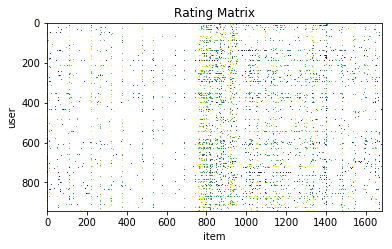

In [10]:
# Rating matrix의 빈 칸을 흰 색, 사용자x영화의 평점이 있는 있는 칸을 다른 색으로 나타내면 다음과 같다.
plt.imshow(df_table)
# 축 이름, 그림 제목 설정
plt.xlabel("item")
plt.ylabel("user")
plt.title("Rating Matrix")
plt.show()

In [11]:
# 가능한 사용자 x 영화 interaction의 개수
matrix_size = n_users*n_items
matrix_size

1586126

In [12]:
# missing value 아닌 셀의 개수
num_rates = df_table.count().sum()
num_rates

100000

In [13]:
# sparsity 계산
sparsity = (1-(num_rates/matrix_size))*100
sparsity

93.69533063577546